# Coal Mining Disasters

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.labelsize': 10, 'font.size': 10, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")

## Step 1: Prepare the data

Text(0.5,0,'Year')

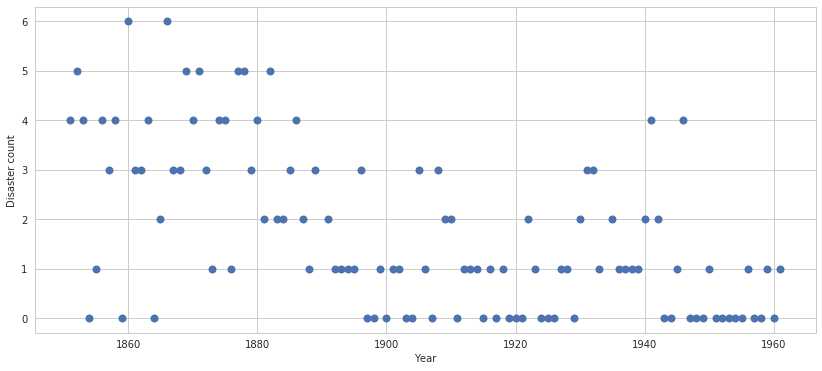

In [2]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year")

## Step 2: Build the model

In [3]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= year, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)    

## Step 3: Sample from the posterior

In [5]:
# We cannot use NUTS because they are discrete variables
# discrete values have no meaningful gradient

with disaster_model:
    posterior_disaster = pm.sample(draws = 2000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to disasters_missing
100%|██████████| 2500/2500 [00:26<00:00, 93.72it/s]


## Step 4: Diagnose convergence of MCMC chains

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3cd9ad1080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3cd99ecf28>]], dtype=object)

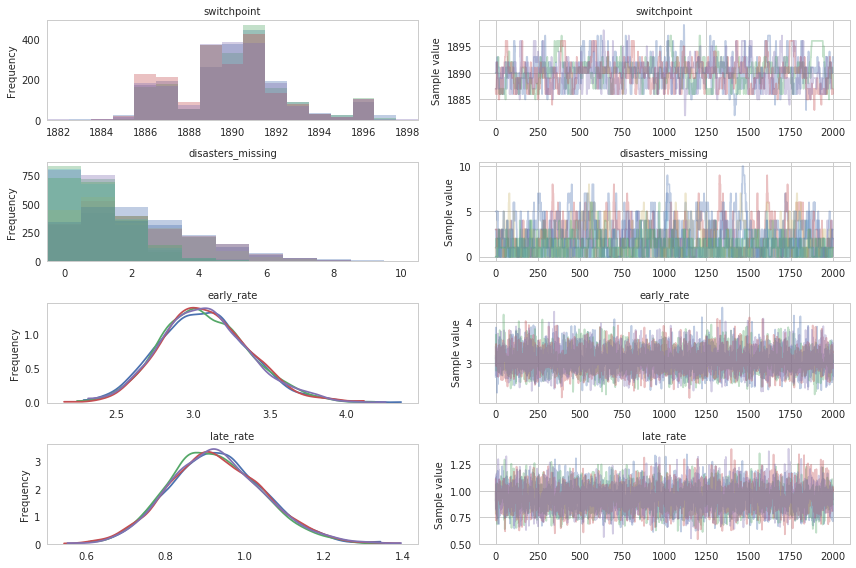

In [6]:
pm.traceplot(posterior_disaster)

In [7]:
pm.gelman_rubin(posterior_disaster)

{'disasters_missing': array([ 1.00639295,  1.00291579]),
 'early_rate': 0.99980769731455554,
 'late_rate': 1.0003061714087937,
 'switchpoint': 1.002682297952993}

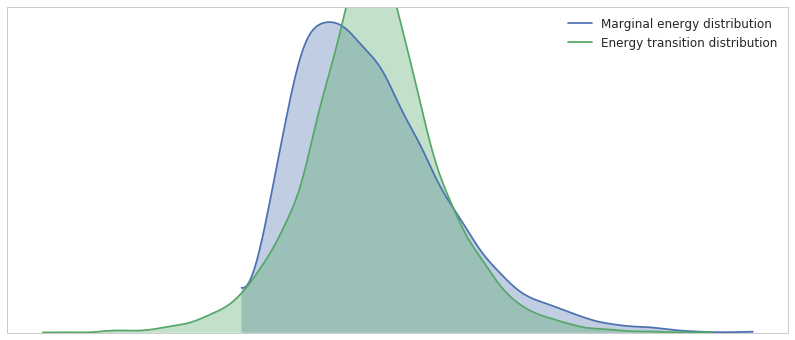

In [8]:
pm.energyplot(posterior_disaster)

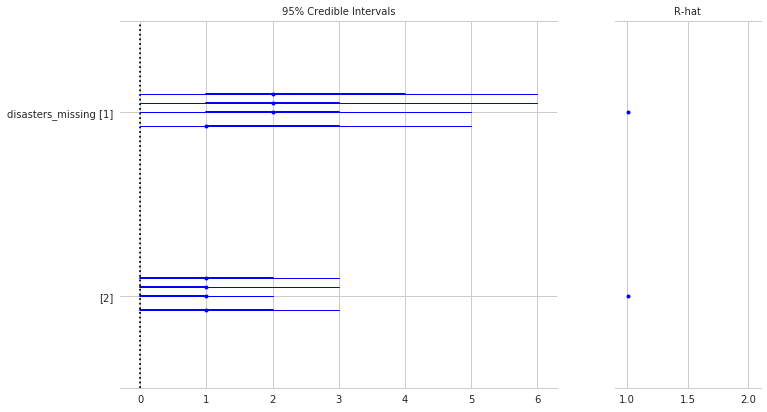

In [11]:
pm.forestplot(posterior_disaster, varnames = ["disasters_missing"])

## Step 5: Criticize the model

In [12]:
pm.summary(posterior_disaster)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,1890.003250,2.545926,0.112495,1886.000000,1896.000000,378.0,1.002682
disasters_missing__0,2.197250,1.792092,0.094045,0.000000,5.000000,315.0,1.006393
disasters_missing__1,0.954250,0.999078,0.032319,0.000000,3.000000,895.0,1.002916
early_rate,3.078712,0.287692,0.004243,2.514952,3.636854,4395.0,0.999808
late_rate,0.928692,0.118223,0.001819,0.698113,1.160020,4686.0,1.000306


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3cd97b3208>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f3cd954b668>], dtype=object)

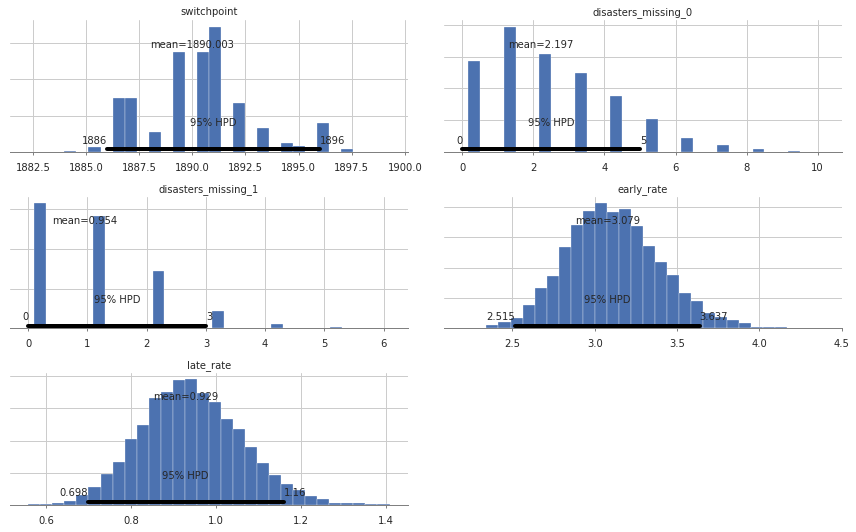

In [13]:
pm.plot_posterior(posterior_disaster)